Data Analysis
===

Data analysis is the process of asking and anwering questions of our data. Is it faster to go through self check-out or employee checkout? Is a home's value related to its size? This module will provide a very brief introductions to a few topics to get you started analyzing data.


Statistical Significance
---

A common question you might ask of your data is, are two things different? Take, for example, checking out at a grocery store in a self-checkout line versus getting checked out by a human employee. In the dataset provided below each row represents one persons checkout time (in seconds) going through both self checkout (U-Scan) and getting checked out by a store employee (Employee_Checkout).

In [1]:
import pandas as pd

# data set originally from http://www.math.hope.edu/swanson/statlabs/data.html
checkout_times_df = pd.read_csv('checkout_times.txt', delim_whitespace=True)
checkout_times_df.head()

,U-Scan,Employee_Checkout
0,341,169
1,450,164
2,199,243
3,57,53
4,33,51


Just by looking at the first 5 data points we can see that for some people self checkout was faster and for others employee checkout was faster. The best we can do to answer the question "which is faster" is to figure out which is faster on average.

total data points: 24

Mean check out times
U-Scan               146.916667
Employee_Checkout    122.125000
dtype: float64

Standard Deviation of checkout times
U-Scan               103.073176
Employee_Checkout     69.417021
dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11362c590>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1136ca710>]], dtype=object)

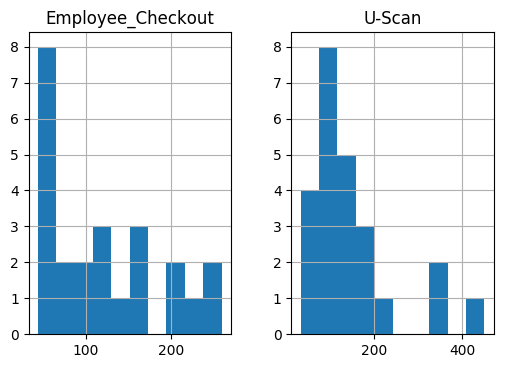

In [2]:
print('total data points: %s\n' % len(checkout_times_df))

print('Mean check out times')
print(checkout_times_df.mean())

print('\nStandard Deviation of checkout times')
print(checkout_times_df.std())

%matplotlib inline
checkout_times_df.hist()

Based on this sample of checkout times from 24 customers, on average employee checkout is faster than self checkout. The average difference was 25 seconds, but if a different set of customers performed the same experiment what's the likelihood that they would come up with contradictory results? We can answer that question with a test of statistical significance.

The precise definitions for tests of statistical significants can be a little convoluded, but their purpose is to help quantify the reliability of your findings. In performing these tests we usually assume the opposite of what we want to prove. The opposite of what we want to prove is called the null hypothesis. In the case above the null hypothesis would be that there is no difference between self checkout and employee checkout. We then calculate the probability that our data supports the null hypothesis. The probability that the null hypothesis is true is called the "p-value". A low p-value means the null hypothesis is unlikely, which means the thing we're trying to prove *is* likely. We'll use a t-test from scipy's stats module to get the probability that this null hypthosis is valid.

In [3]:
from scipy import stats

pval = stats.ttest_rel(
    checkout_times_df['U-Scan'],
    checkout_times_df['Employee_Checkout']
).pvalue
print(pval)

0.270406420767


The p-value is 0.27 which means there's a 27% chance that the checkout times between self checkout and employee checkout aren't different at all. Most statisticians would claim that, based on this data, there's not enough evidence to reject the null hypothesis. In other words, we can't say that either employee checkout or self checkout is faster based on our data.

In most cases you've performed an experiment (or gathered data) with hopes of rejecting the null hypothesis (or actually proving something). In general small p-values mean we can make a statistical claim about two things being different. But how small is small enough? There's not a great answer to that question, but the rule of thumb for many researchers is that if p is smaller than 0.05 you can claim statistical significance and if it's larger than 0.05 you can't.

Correlation
---

Let's return to the nbs sql database and look at data measuring engagement with musicians and bands on social media across Facebook, Twitter, YouTube and Instagram.

In [4]:
import sqlite3 as lite

con = lite.connect('nbs.db')
query = 'select * from social_data'
social_df = pd.read_sql(query, con, index_col='artist_id')
con.close()
print('there are %s rows in the data table' % len(social_df))
social_df.head()

there are 3760 rows in the data table


,FaceBookPageLikes,TwitterFollowers,YouTubeViews,InstagramLikes,InstagramFollowers
artist_id,,,,,
500,4797.0,1395.0,NaN,NaN,NaN
744,NaN,224.0,44287.0,NaN,NaN
952,4142.0,64.0,130279.0,NaN,NaN
1017,NaN,NaN,2966.0,NaN,NaN
1086,28980.0,43405.0,402054.0,56832.0,7653.0


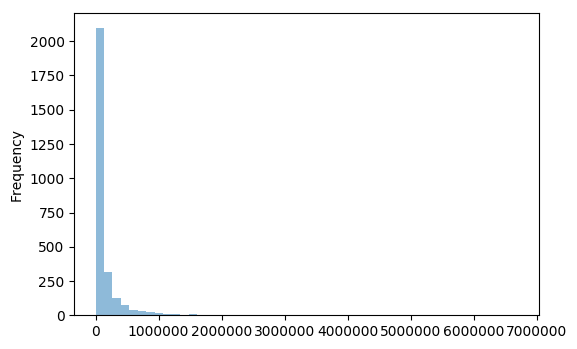

In [5]:
social_df['YouTubeViews'].plot.hist(bins=50, alpha=0.5)

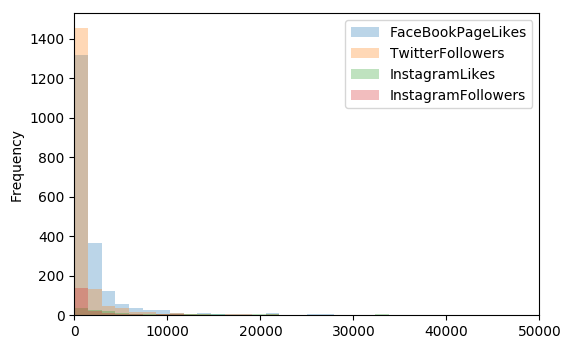

In [6]:
social_df.drop('YouTubeViews', axis=1).plot.hist(bins=750, alpha=0.3, xlim=[0,50000])

Many statistical methods assume that data is normally distributed so it's always nice to find that normal looking histograms. The distributions of all five social features, however, are very right skewed. Fortunately there are ways to transform non-normal data to make it look normal. In this case we'll try taking the log of all of the values.

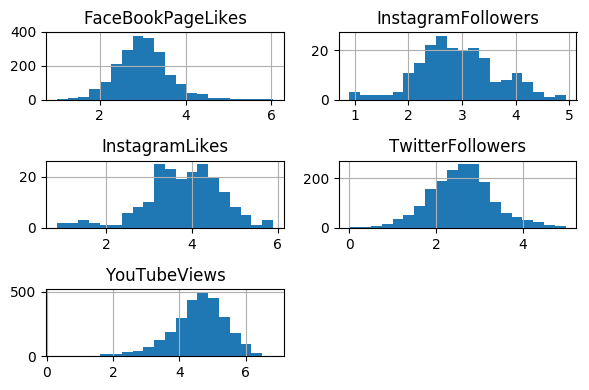

In [7]:
import numpy as np
from matplotlib import pyplot

log_df = np.log10(social_df)
log_df.hist(bins=20)
pyplot.tight_layout()  # this line is usually necessary when you have multiple subplots

It looks like that did the trick! Now that our data is normally distributed we can check whether any of these variables are correlated. Pandas dataframes have a built-in correlation method that gives correlations coefficients between every pair of features.

In [8]:
log_df.corr()

,FaceBookPageLikes,TwitterFollowers,YouTubeViews,InstagramLikes,InstagramFollowers
FaceBookPageLikes,1.000000,0.410080,0.298984,0.466838,0.525900
TwitterFollowers,0.410080,1.000000,0.189475,0.540367,0.691184
YouTubeViews,0.298984,0.189475,1.000000,0.221682,0.322739
InstagramLikes,0.466838,0.540367,0.221682,1.000000,0.851220
InstagramFollowers,0.525900,0.691184,0.322739,0.851220,1.000000


Not surprisingly Instagram like are highly correlated with Instagram followers. We could also get correlation coefficient and the corresponding p-values from stat's personr method. In this case we have to do a little bit of extra work to drop any rows that have NA values. Let's dig into the correlation between Instagram likes and Instagram followers.

In [9]:
# dropping any rows that have NA values for either InstagramLikes or InstagramFollowers
log_df_inst = log_df[['InstagramLikes', 'InstagramFollowers']].dropna()

stats.pearsonr(log_df_inst['InstagramLikes'], log_df_inst['InstagramFollowers'])

(0.8512202450831523, 2.4120520518988779e-57)

The first value in the resultig tuple is the correlation coefficient (which matches what we got from panda's corr method), and the second is the p-value. The very very small p-value means that we can be very confident that these two features are indeed positively correlated.

Let's go a step further and plot the results in order to make a conjecture about the relationship between the two variables.

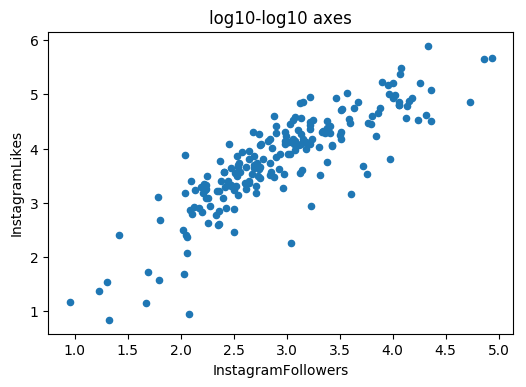

In [10]:
log_df.plot(kind='scatter', x='InstagramFollowers', y='InstagramLikes', title='log10-log10 axes')

The relationship looks linear. Let's try to fit a few functions to the data.

In [11]:
from matplotlib import pyplot

x = log_df_inst['InstagramFollowers']
y = log_df_inst['InstagramLikes']

(m, b) = np.polyfit(x, y, 1)
print('the slope and y-intercept of the best fit line are %s and %s' % (m, b))

(C2, C1, C0) = np.polyfit(x, y, 2)
print('the coefficients of the second order polynomial are %s, %s, and %s' % (C0, C1, C2))

the slope and y-intercept of the best fit line are 1.06814198321 and 0.643323493171
the coefficients of the second order polynomial are -1.27052575888, 2.41263664103, and -0.222587639001


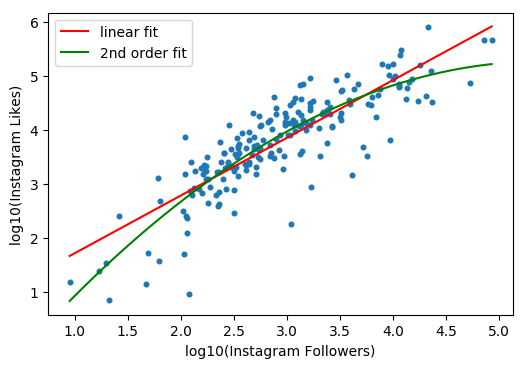

In [12]:
# create dummy points along the x-axis to plot our fit curves against
xi = np.linspace(min(x), max(x), 100)

# define functions that map the the linear (f1) and 2nd order (f2) curves to values along the y-axis
def f1(xi):
    return b + m*xi

def f2(xi):
    return C0 + C1*xi + C2*xi*xi

pyplot.scatter(x, y, s=11, label=None)  # plot the data
pyplot.plot(xi, f1(xi), c='r', label='linear fit')  # plot the linear fit
pyplot.plot(xi, f2(xi), c='g', label='2nd order fit')  # plot the 2nd order fit

pyplot.legend(loc='upper left')
pyplot.xlabel('log10(Instagram Followers)')
pyplot.ylabel('log10(Instagram Likes)')
pyplot.show()

Both the linear and the 2nd order fits go right through the middle of our data points, but the 2nd order fit does a little better at the ends. We can measure the "goodness" of the fit with the [Coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) (more commonly referred to as the "r-squared" value). r-squared varies between 0 and 1, 1 meaning the fit line passes through every data point (perfect fit) and values close to 0 meaning the line does a very poor job fitting the data. There are built in python functions to compute r-squared, but it's [definition](https://en.wikipedia.org/wiki/Coefficient_of_determination#Definitions) is short so let's write our own function to calculate it.

In [13]:
def rsquared(f, x, y):
    yhat = f(x)
    ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    return ssreg / sstot

rsq_linear = rsquared(f1, x, y)
rsq_2nd = rsquared(f2, x, y)

print('r-squared for linear fit: %s' % rsq_linear)
print('r-squared for 2nd order fit: %s' % rsq_2nd)

r-squared for linear fit: 0.724575905639
r-squared for 2nd order fit: 0.755966152427


The r-square gives us a way to quantify our intuition that the second order polynomial fits the data a little better than the straight line. This is to be expected. The extra coefficient in the 2nd order equation gives the function an extra degree of freedom. In fact, polynomials can have any number of degrees of freedom and it can be tempting to keep increasing the order of the polynomial until the curve fits the data perfectly. But look what happens when we fit the data to a 30th order polynomial.

r-squared for 30th order fit: 0.774511728656


/usr/local/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


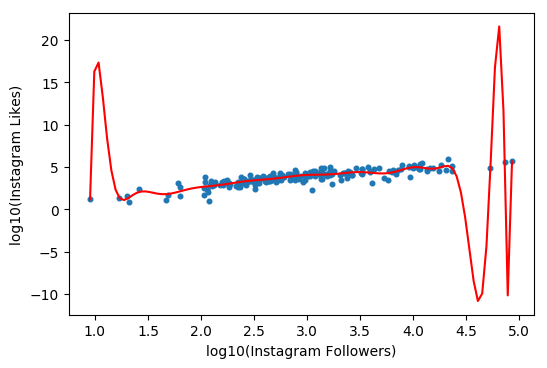

In [14]:
C30 = np.polyfit(x, y, 30)
def fN(xi, C):
    """function to calculate y values for polynomial of arbitrary degree"""
    yi = np.zeros(len(xi))
    N = len(C)
    for i in range(N):
        yi += C[(N-1)-i] * xi**i
    return yi

def f30(xi):
    return fN(xi, C=C30)

pyplot.scatter(x, y, s=11, label=None)  # plot the data
pyplot.plot(xi, f30(xi), c='r')  # plot the 30th order polynomial
pyplot.xlabel('log10(Instagram Followers)')
pyplot.ylabel('log10(Instagram Likes)')

print('r-squared for 30th order fit: %s' % rsquared(f30, x, y))

The r-squared value for the 30th degree polynomial is slightly better than that of the 2nd degree polynomial. It also passes right through the points on the end, but it's obvious that this function is a poor representation of the relationship between the two variables. As a rule of thumb, if increasing the degrees of freedom of a fitting curve only marginally improves r-squared, go with a lower degree fit. In our case either the linear or 2nd degree fit would be a good choice.

   **Note:** Choosing a function with too many degrees of freedom is called over fitting. There's a systematic way to avoid over fitting by splitting your data into two sets, a training set and a testing set. You can fit various models to the trainig set and then calculate the r-squared value on the test set. The best fitting function will generally be the one that fits the test set best. This method of avoiding overfitting is known as [cross validation](https://medium.com/towards-data-science/train-test-split-and-cross-validation-in-python-80b61beca4b6) and is applicable for many other machine learning problems.
   
A best fit curve allows us to put data in context or make predictions about what to expect with new data. For instance, let's say we know that an artist has 1000 Instagram followers and 100 likes. How is that artist doing relative to other artists?

Using the linear fit we can calculate the expected number of Instagram likes given the number of followers.

In [15]:
follower_count = 1000

# since our fits were performed on log-transformed data, we have to log-transform this data point as well
log_follower_count = np.log10(follower_count)
expected_log_like_count = f1(log_follower_count)

# now we have to undo the log transform
expected_like_count = 10**expected_log_like_count
print(expected_like_count)

7042.86628183


We'd expect an artist with 1000 Instagram followers to have around 7,000 likes. Since this artist has many fewer, we might conclude that the artist has relatively low engagement on instagram. We might use a similar approach to flag artists they may have bought followers.

If we knew the number of followers and not the number of likes, we could also use our fit curves to predict the number of likes. In the case of an artist with 1000 followers our best guess for number of likes would be around 7,000. While that guess won't be exactly right all of the time, we assume that using this method to guess a value for likes will *on average* be closer than any other guess.